# Train RoBERTa Model with PyTorch in SageMaker

In [2]:
import pandas as pd
import numpy as np
import json

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader

from transformers import RobertaModel, RobertaConfig
from transformers import RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
# Loading the datasets
train = pd.read_csv('balanced/sentiment-train/train.csv')
validation = pd.read_csv('balanced/sentiment-validation/validation.csv')

In [3]:
train.head(1)

,Unnamed: 0,review_id,sentiment,label_ids,input_ids,review_body,date
0,0,12637,-1,0,"[0, 100, 489, 667, 7, 465, 10, 3723, 2911, 783...",I keep trying to find a peplum that works for ...,2023-01-06T17:39:55Z


In [4]:
validation.head(1)

,Unnamed: 0,review_id,sentiment,label_ids,input_ids,review_body,date
0,0,19426,1,2,"[0, 713, 16, 10, 182, 3793, 8, 27360, 28033, 1...",This is a very soft and feminine chemise. it i...,2023-01-06T17:39:55Z


# Train Model in SageMaker

In [4]:
import sagemaker
import boto3
import pandas as pd

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker')

sm_runtime = boto3.client('sagemaker-runtime')

sagemaker_session = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name
prefix = 'sagemaker-scikit-learn-2023-01-06-17-33-49-347/output'

In [5]:
# Location of train and validation data
processed_train_data_s3_uri = 's3://{}/{}/sentiment-train/train.csv'.format(bucket, prefix)
processed_validation_data_s3_uri = 's3://{}/{}/sentiment-validation/validation.csv'.format(bucket, prefix)

In [6]:
!aws s3 ls --recursive $processed_train_data_s3_uri

2023-01-06 17:39:59    4895996 sagemaker-scikit-learn-2023-01-06-17-33-49-347/output/sentiment-train/train.csv


In [7]:
!aws s3 ls --recursive $processed_validation_data_s3_uri

2023-01-06 17:40:00     278047 sagemaker-scikit-learn-2023-01-06-17-33-49-347/output/sentiment-validation/validation.csv


In [8]:
test = pd.read_csv(processed_train_data_s3_uri)
test[['input_ids', 'label_ids']]

,input_ids,label_ids
0,"[0, 100, 489, 667, 7, 465, 10, 3723, 2911, 783...",0
1,"[0, 1620, 5, 986, 37102, 2801, 6, 5, 12189, 17...",0
2,"[0, 24450, 350, 251, 734, 627, 39328, 16, 5784...",0
3,"[0, 100, 657, 42, 23204, 6, 941, 5, 21764, 4, ...",2
4,"[0, 2847, 6, 42, 3588, 16, 2778, 3473, 6, 53, ...",1
...,...,...
5532,"[0, 771, 10852, 42, 452, 328, 24, 10698, 1528,...",2
5533,"[0, 10365, 1810, 328, 5, 1521, 16, 11962, 53, ...",0
5534,"[0, 713, 19220, 118, 3588, 16, 2230, 99, 939, ...",2
5535,"[0, 100, 794, 42, 3588, 804, 8, 269, 770, 7, 6...",0


## Create Data Channels

Setting up the input data channels. This is done by wrapping the S3 locations in a *TrainingInput* object to use with SageMaker Training Job

In [9]:
# Create training data channel
s3_input_train_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_train_data_s3_uri
)

# Create validation data channel
s3_input_validation_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_validation_data_s3_uri
)

data_channels = {
    'train': s3_input_train_data,
    'validation': s3_input_validation_data
}

## Configure Hyperparameters

Setting the hyperparameters that will be passed into the PyTorch estimator for the hyperparameters argument.

In [10]:
max_seq_length=128 # maximum number of input tokens passed to BERT model
freeze_bert_layer=False # specifies the depth of training within the network
epochs=3
learning_rate=2e-5
train_batch_size=256
train_steps_per_epoch=50
validation_batch_size=256
validation_steps_per_epoch=50
seed=42
run_validation=True

train_instance_count=1
train_instance_type='ml.c5.9xlarge'
train_volume_size=256
input_mode='File'

In [11]:
hyperparameters={
    'max_seq_length': max_seq_length,
    'freeze_bert_layer': freeze_bert_layer,
    'epochs': epochs,
    'learning_rate': learning_rate,
    'train_batch_size': train_batch_size,
    'train_steps_per_epoch': train_steps_per_epoch,
    'validation_batch_size': validation_batch_size,
    'validation_steps_per_epoch': validation_steps_per_epoch,    
    'seed': seed,
    'run_validation': run_validation
}

## Evaluation Metrics

The evaluation metric used to evaluate our model is loss and accuracy.

The Loss function we are using is Categorical Cross-Entropy. Cross entropy loss is commonly used in classification tasks. 

In [12]:
metric_definitions = [
     {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9.]+)'},
     {'Name': 'validation:accuracy', 'Regex': 'val_acc: ([0-9.]+)'},
]

## Setup Debugger and Profiler

In [13]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

In [14]:
debugger_hook_config = DebuggerHookConfig(
    s3_output_path='s3://{}'.format(bucket),
)

In [15]:
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10)
)

In [16]:
rules=[ProfilerRule.sagemaker(rule_configs.ProfilerReport())]

## Train Model

Prepare the PyTorch model to run as a SageMaker Training Job in a seperate Python file called *train.py*.

In [45]:
from sagemaker.pytorch import PyTorch as PyTorchEstimator


estimator = PyTorchEstimator(
    entry_point='train.py',
    source_dir='src',
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    py_version='py3', # dynamically retrieves the correct training image (Python 3)
    framework_version='1.6.0', # dynamically retrieves the correct training image (PyTorch)
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    input_mode=input_mode,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
    rules=rules
)

Launch the SageMaker Training Job which will be fitting the model to the dataset.

In [46]:
estimator.fit(
    inputs= data_channels, 
    wait=False
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-01-09-17-09-57-083


In [47]:
training_job_name = estimator.latest_training_job.name
print(training_job_name)

pytorch-training-2023-01-09-17-09-57-083


In [48]:
%%time

estimator.latest_training_job.wait(logs=False)


2023-01-09 17:09:57 Starting - Starting the training job...
2023-01-09 17:10:13 Starting - Preparing the instances for training............
2023-01-09 17:11:21 Downloading - Downloading input data..
2023-01-09 17:11:34 Training - Downloading the training image
2023-01-09 17:11:41 Training - Training image download completed. Training in progress...........................................................................................................................................................................................................................................................................................................................................................................................................................................................
2023-01-09 17:48:59 Uploading - Uploading generated training model.....................................
2023-01-09 17:52:12 Completed - Training job completed
CPU times: user 2.31 s, sys: 174 ms, total: 2.49 

Review the training metrics.

In [49]:
df_metrics = estimator.training_job_analytics.dataframe()
df_metrics

,timestamp,metric_name,value
0,0.0,validation:loss,1.13
1,1260.0,validation:loss,1.09
2,1740.0,validation:loss,0.74
3,0.0,validation:accuracy,32.81
4,1260.0,validation:accuracy,36.72
5,1740.0,validation:accuracy,66.41


INFO:matplotlib.font_manager:generated new fontManager


<AxesSubplot:xlabel='timestamp'>

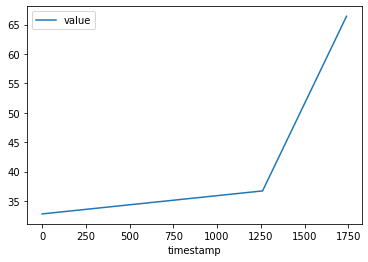

In [50]:
df_metrics.query("metric_name=='validation:accuracy'").plot(x='timestamp', y='value')

In [51]:
profiler_report_s3_uri = "s3://{}/{}/rule-output/ProfilerReport/profiler-output".format(bucket, training_job_name)

In [52]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

class SentimentPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, 
                         sagemaker_session=sagemaker_session, 
                         serializer=JSONLinesSerializer(),
                         deserializer=JSONLinesDeserializer())

In [53]:
import time
from sagemaker.pytorch.model import PyTorchModel

timestamp = int(time.time())

pytorch_model_name = '{}-{}-{}'.format(training_job_name, 'pt', timestamp)

model = PyTorchModel(name=pytorch_model_name,
                     model_data=estimator.model_data,
                     predictor_cls=SentimentPredictor,
                     entry_point='inference.py',
                     source_dir='src',
                     framework_version='1.6.0',
                     py_version='py3',
                     role=role)

In [54]:
import time

pytorch_endpoint_name = '{}-{}-{}'.format(training_job_name, 'pt', timestamp)

print(pytorch_endpoint_name)

pytorch-training-2023-01-09-17-09-57-083-pt-1673290741


In [55]:
%%time

predictor = model.deploy(initial_instance_count=1, 
                         instance_type='ml.m5.large', 
                         endpoint_name=pytorch_endpoint_name)

INFO:sagemaker:Creating model with name: pytorch-training-2023-01-09-17-09-57-083-pt-1673290741
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-01-09-17-09-57-083-pt-1673290741
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-01-09-17-09-57-083-pt-1673290741


----------!CPU times: user 2min 37s, sys: 9.44 s, total: 2min 47s
Wall time: 7min 52s


In [57]:
inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = SentimentPredictor(endpoint_name=pytorch_endpoint_name,
                               sagemaker_session=sagemaker_session)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

Predicted class 1 with probability 0.9308392405509949
Predicted class 0 with probability 0.5391462445259094
Predicted class -1 with probability 0.5177765488624573


In [58]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2023-01-09-17-09-57-083-pt-1673290741
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2023-01-09-17-09-57-083-pt-1673290741
